# EQBSCQ: Experimental Quantum Battle of the Sexes: Classical & Quantum

## 1. Installation of libraries

Instalación de versiones compatibles

In [ ]:
!pip install -U -c https://qisk.it/1-0-constraints \
    qiskit==2.0.1 \
    qiskit-aer==0.17.0 \
    qiskit-ibm-runtime==0.39.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.9/363.9 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 7.3 MB/s eta 0:00:00


## 2. Imports and versions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os, time
import qiskit, qiskit_aer
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FuncFormatter
from collections import defaultdict
import networkx as nx

from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import StatePreparation
from qiskit.transpiler import Layout
from qiskit_aer import AerSimulator
from qiskit.result import marginal_counts

from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    SamplerV2 as Sampler,
)

from google.colab import files
import time
import pandas as pd
from tabulate import tabulate

print("== Librerías y versiones ==")
print(f" qiskit     : {qiskit.__version__}")
print(f" aer        : {qiskit_aer.__version__}")
print(f" numpy      : {np.__version__}")
print(f" matplotlib : {plt.matplotlib.__version__}\n")

== Librerías y versiones ==
 qiskit     : 2.0.1
 aer        : 0.17.0
 numpy      : 2.0.2
 matplotlib : 3.10.0



## 3. Connection to IBM Quantum Runtime

In [ ]:
# Save your token the first time (only if you haven't saved it yet):
QiskitRuntimeService.save_account(
    channel="ibm_quantum",
    token="9477267a9ca23c1d9d15a565a6e429febceafd6cfb7ec22fb6462b74fd8eb845e691655e2644cabe4584d70a079ab813f5919113b917a0b09e18c3b52a82f9c3"  # <<<––– Token
)
service = QiskitRuntimeService(channel="ibm_quantum")  # reads the saved token

<ipython-input-4-752aa5671c73>:6: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud" and "local" will be the only valid channels. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(channel="ibm_quantum")  # ya lee el token guardado


## 4. Classic Game: Battle of the Sexes

In [ ]:
classical = type(
    "ClassicalCoordinationGame", (), {
        "__init__": lambda self: setattr(
            self, "payoff",
            {(0,0):(3,2),(1,1):(2,3),(0,1):(0,0),(1,0):(0,0)}
        ),
        "mixed_equilibrium_payoffs": lambda self: (
            3*(3/5)*(2/5) + 2*((1-3/5)*(1-2/5)),
            2*(2/5)*(3/5) + 3*((1-2/5)*(1-3/5))
        )
    }
)()
EA_cl, EB_cl = classical.mixed_equilibrium_payoffs()

print(f"Expected payoff Alice: {EA_cl}")
print(f"Expected payoff Bob: {EB_cl}")

Pago esperado Alice: 1.2
Pago esperado Bob: 1.2


## 5. QuantumCoordGameRuntime class

In [ ]:
class QuantumCoordGameRuntime:
    def __init__(self,
                 gamma=None,
                 shots=2048,
                 Strategy='I',
                 use_hardware=True,
                 use_multicrt=False,
                 Pairs=None,
                 Num_executions=None):
        self.shots = shots
        self.Strategy = Strategy
        self.use_multicrt = use_multicrt
        self.use_hardware = use_hardware
        self.qubits = []

        if use_multicrt:
            # Parameters for multi-circuit (lists of alpha/beta)
            self.Pairs = Pairs
            self.alpha, self.beta = [], []
            for g in np.linspace(0, np.pi, Num_executions):
                self.alpha.append(np.cos(g/2))
                self.beta.append(np.sin(g/2))
        else:
            # Simple entangled state
            self.alpha = np.cos(gamma/2)
            self.beta  = np.sin(gamma/2)

        # Backend selection
        if self.use_hardware:
            self.backend = service.least_busy(min_num_qubits=62, simulator=False)
            self.sampler = Sampler(mode=self.backend)
            self.sampler.options.default_shots = shots
        else:
            self.backend = AerSimulator()
            self.sampler = self.backend

    def _select_best_adjacent_qubits(self):
        if self.backend.coupling_map is None:
            return [0, 1]
        edges = self.backend.coupling_map.get_edges()
        cx_errors = {}
        for i, j in edges:
            props = self.backend.target.get("cx", {}).get((i, j), None)
            if props is not None:
                cx_errors[(i, j)] = props.error
        if not cx_errors:
            print("⚠️ No CX data found; defaulting to [0,1].")
            return [0, 1]
        return list(min(cx_errors, key=cx_errors.get))

    def _build_circuit(self, gateA, gateB):
        if self.use_multicrt:
            qc = QuantumCircuit(len(self.Pairs)*2, len(self.Pairs)*2)
            for num, (q0, q1) in enumerate(self.Pairs):
                # 1) Prepare entanglement on qubits [2*num,2*num+1]
                qc.append(StatePreparation(
                    [self.alpha[num], 0, 0, self.beta[num]]),
                    [2*num, 2*num+1]
                )
                # 2) apply gates to this block
                for gate, offset in ((gateA, 0), (gateB, 1)):
                    target = 2*num + offset
                    if gate == 'H':      qc.h(target)
                    elif gate == 'R(pi_4)': qc.ry(np.pi/4, target)
                    elif gate == 'R(pi)':   qc.ry(np.pi, target)
                    # 'I' does nothing
                # 3) measure this pair
                qc.measure([2*num, 2*num+1], [2*num, 2*num+1])
        else:
            # single-pair
            self.qubits = self._select_best_adjacent_qubits()
            qc = QuantumCircuit(2, 2)
            qc.append(StatePreparation([self.alpha, 0, 0, self.beta]), [0, 1])
            for gate, idx in ((gateA, 0), (gateB, 1)):
                if gate == 'H':      qc.h(idx)
                elif gate == 'R(pi_4)': qc.ry(np.pi/4, idx)
                elif gate == 'R(pi)':   qc.ry(np.pi, idx)
            qc.measure([0, 1], [0, 1])

        return qc

    def _transpile(self, qc):
        if self.use_hardware and self.qubits:
            return transpile(
                qc,
                backend=self.backend,
                initial_layout=self.qubits,
                layout_method='sabre',
                routing_method='sabre',
                optimization_level=3
            )
        return transpile(qc, backend=self.backend)

    def analyze_entangled_pairs(self, result, circuit_index=0):
        all_counts = result[0].data.c.get_counts()
        analysis = {}
        for i, (q1, q2) in enumerate(self.Pairs):
            c1, c2 = 2*i, 2*i+1
            pair_counts = marginal_counts(all_counts, [c1, c2])
            counts = {'00':0,'01':0,'10':0,'11':0}
            counts.update(pair_counts)
            analysis[f'pair_{i}'] = {'qubits': (q1, q2), 'counts': counts}
        return analysis

    def payoffs(self):
        qc  = self._build_circuit(self.Strategy, self.Strategy)
        tqc = self._transpile(qc)

        if self.use_multicrt:
            job = self.sampler.run([tqc])
            res = job.result(timeout=600)
            return self.analyze_entangled_pairs(res)

        # single-circuit
        if self.use_hardware:
            job = self.sampler.run([tqc])
            res = job.result(timeout=600)
            counts = res[0].data.c.get_counts()
            total = sum(counts.values())
            p00 = counts.get('00',0)/total if total else 0
            p11 = counts.get('11',0)/total if total else 0
        else:
            res = self.sampler.run(tqc, shots=self.shots).result()
            counts = res.get_counts()
            p00 = counts.get('00',0)/self.shots
            p11 = counts.get('11',0)/self.shots

        EA  = 3*p00 + 2*p11
        EB  = 2*p00 + 3*p11
        Err = 1 - (p00 + p11)
        return EA, EB, Err

## 6. Architecture

QPU architecture with up to 35 possible two-qubit circuits using the first error minimisation strategy

In [ ]:
list_arq_127qb = [[0, 1], [3, 4], [6, 7], [9, 10], [12, 13], [18, 19], [21, 22],
 [24, 25], [27, 28], [30, 31], [37, 38], [40, 41], [43, 44], [46, 47], [49, 50],
  [56, 57], [59, 60], [62, 63], [65, 66], [68, 69], [75, 76], [78, 79], [81, 82],
   [84, 85], [87, 88], [94, 95], [97, 98], [100, 101], [103, 104], [106, 107],
    [113, 114], [116, 117], [119, 120], [122, 123], [125, 126]]

Standard of 31 circuits for this research

In [ ]:
list_par_qb = list_arq_127qb[:31]

## 7. Sweeping γ in simulator

### 7.1 Simulator

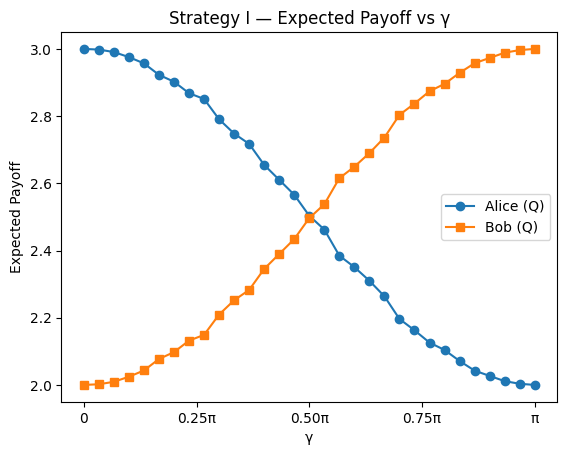

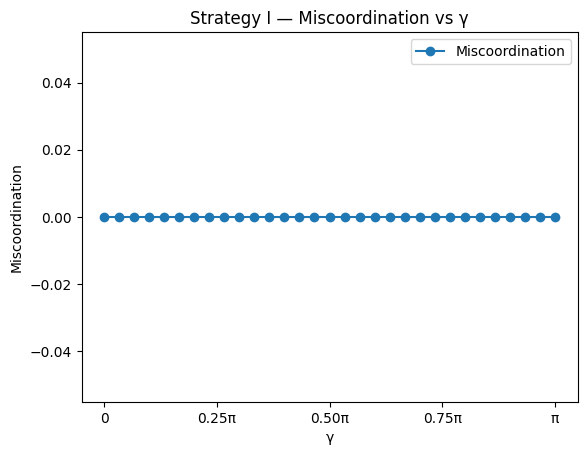

In [ ]:
# Only strategy 'I'
gammas = np.linspace(0, np.pi, 31)
strategy = 'I'

EA_qs, EB_qs, Err_qs = [], [], []

for g in gammas:
    game = QuantumCoordGameRuntime(
        gamma=g,
        shots=2048,
        Strategy=strategy,
        use_hardware=False,
        use_multicrt=False
    )
    EA, EB, Err = game.payoffs()
    EA_qs.append(EA)
    EB_qs.append(EB)
    Err_qs.append(Err)

# Function to format X-axis labels as multiples of π
def pi_formatter(x, pos):
    frac = x / np.pi
    if np.isclose(frac, 0): return "0"
    elif np.isclose(frac, 1): return "π"
    elif frac.is_integer(): return f"{int(frac)}π"
    else: return f"{frac:.2f}π"

# Plot of Payoff vs γ for I
plt.figure()
plt.plot(gammas, EA_qs, '-o', label='Alice (Q)')
plt.plot(gammas, EB_qs, '-s', label='Bob (Q)')
plt.title(f'Strategy {strategy} — Expected Payoff vs γ')
plt.xlabel("γ")
plt.ylabel("Expected Payoff")
plt.legend()

ax1 = plt.gca()
ax1.xaxis.set_major_locator(MultipleLocator(np.pi / 4))
ax1.xaxis.set_major_formatter(FuncFormatter(pi_formatter))
"""
path1 = "/content/drive/MyDrive/Works/Quantum/Code/Result/0_Strategie_I/Simulacion/0_Simulacion_Minimizada_strategy_I.png"
plt.savefig(path1, dpi=300, bbox_inches='tight')
print(f"[✓] First image saved at: {path1}")
"""
plt.show()
plt.close()

# Plot of Miscoordination vs γ for I
plt.figure()
plt.plot(gammas, Err_qs, '-o', label='Miscoordination')
plt.title(f'Strategy {strategy} — Miscoordination vs γ')
plt.xlabel("γ")
plt.ylabel("Miscoordination")
plt.legend()

ax2 = plt.gca()
ax2.xaxis.set_major_locator(MultipleLocator(np.pi / 4))
ax2.xaxis.set_major_formatter(FuncFormatter(pi_formatter))
'''
path2 = "/content/drive/MyDrive/Works/Quantum/Code/Result/0_Strategie_I/Simulacion/1_Simulacion_Descoordinacion_Minimizada_strategy_I.png"
plt.savefig(path2, dpi=300, bbox_inches='tight')
print(f"[✓] Second image saved at: {path2}")
'''
plt.show()
plt.close()

### 7.2 Simulator with noise

p_cx calculado dinámicamente: 0.0225
[✓] Primera imagen guardada en: /content/drive/MyDrive/Works/Quantum/Code/Result/0_Strategie_I/Simulador_Ruido/0_Simulacion_Minimizada_strategy_I.png


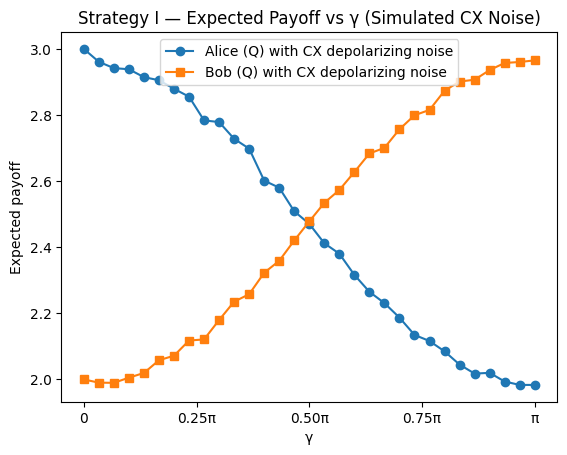

[✓] Segunda imagen guardada en: /content/drive/MyDrive/Works/Quantum/Code/Result/0_Strategie_I/Simulador_Ruido/1_Simulacion_Descoordinacion_Minimizada_strategy_I.png


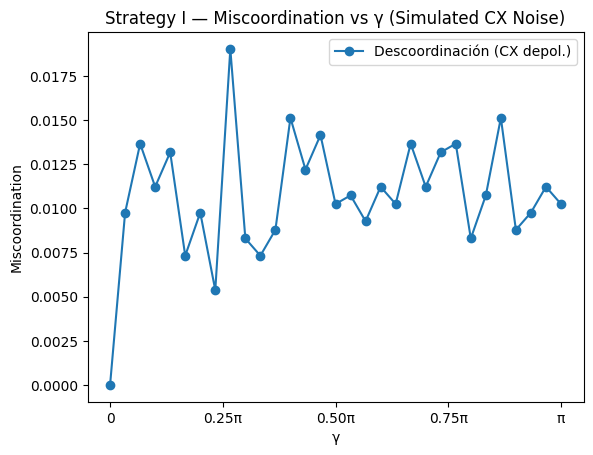

In [ ]:
# Calculate p_cx as half of the observed standard deviation
Mis_Real_S_R = 0.045
p_cx = Mis_Real_S_R / 2
print(f"Dynamically calculated p_cx: {p_cx}")

# Create a noise model with depolarizing error on CX gates
error = depolarizing_error(p_cx, 2)
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error, ['cx'])
basis_gates = noise_model.basis_gates

# Create simulator with the noise model
noisy_sim = AerSimulator(noise_model=noise_model, basis_gates=basis_gates)

# Sweep gamma values
gammas = np.linspace(0, np.pi, 31)
strategy = 'I'
EA_qs, EB_qs, Err_qs = [], [], []

for g in gammas:
    game = QuantumCoordGameRuntime(
        gamma=g,
        shots=2048,
        Strategy=strategy,
        use_hardware=False,
        use_multicrt=False
    )
    game.backend = noisy_sim
    game.sampler = noisy_sim

    EA, EB, Err = game.payoffs()
    EA_qs.append(EA)
    EB_qs.append(EB)
    Err_qs.append(Err)

# Formatter for X-axis (multiples of pi)
def pi_formatter(x, pos):
    frac = x / np.pi
    if np.isclose(frac, 0): return "0"
    elif np.isclose(frac, 1): return "π"
    elif frac.is_integer(): return f"{int(frac)}π"
    else: return f"{frac:.2f}π"

# --- Plot of Payoff vs γ ---
fig1 = plt.figure()
plt.plot(gammas, EA_qs, '-o', label='Alice (Q) with CX depolarizing noise')
plt.plot(gammas, EB_qs, '-s', label='Bob (Q) with CX depolarizing noise')
plt.title(f'Strategy {strategy} — Expected Payoff vs γ (Simulated CX Noise)')
plt.xlabel("γ")
plt.ylabel("Expected payoff")
plt.legend()

# Save image (uncomment if you want to save)
path1 = "/content/drive/MyDrive/Works/Quantum/Code/Result/0_Strategie_I/Simulador_Ruido/0_Simulacion_Minimizada_strategy_I.png"
plt.savefig(path1, dpi=300, bbox_inches='tight')
print(f"[✓] First image saved at: {path1}")
plt.show()
plt.close(fig1)

# --- Plot of Miscoordination vs γ ---
fig2 = plt.figure()
plt.plot(gammas, Err_qs, '-o', label='Miscoordination (CX depol.)')
plt.title(f'Strategy {strategy} — Miscoordination vs γ (Simulated CX Noise)')
plt.xlabel("γ")
plt.ylabel("Miscoordination")
plt.legend()
ax2 = plt.gca()
ax2.xaxis.set_major_locator(MultipleLocator(np.pi / 4))
ax2.xaxis.set_major_formatter(FuncFormatter(pi_formatter))

# Save image (uncomment if you want to save)
path2 = "/content/drive/MyDrive/Works/Quantum/Code/Result/0_Strategie_I/Simulador_Ruido/1_Simulacion_Descoordinacion_Minimizada_strategy_I.png"
plt.savefig(path2, dpi=300, bbox_inches='tight')
print(f"[✓] Second image saved at: {path2}")
plt.show()
plt.close(fig2)

## 8. Execution on real hardware

Statistics

In [ ]:
def calculate_distributed_averages(data_list, groups=31):
    averages = []
    for i in range(groups):
        # Select elements of group i: i, i+31, i+62, etc.
        group_elements = data_list[i::groups]
        # Calculate the average of the group
        average = sum(group_elements) / len(group_elements)
        averages.append(average)
    return averages
def calculate_distributed_variance_stddev(data_list, average, groups=31):
    variance = []
    stddev = []
    for i in range(groups):
        # Select elements of group i: i, i+31, i+62, etc.
        group_elements = data_list[i::groups]
        # Calculate the variance of the group
        group_variance = sum((x - average[i]) ** 2 for x in group_elements) / (len(group_elements) - 1)
        variance.append(group_variance)
        group_stddev = group_variance ** 0.5
        stddev.append(group_stddev)
    return variance, stddev

Execution

In [ ]:
P00.clear()
P01.clear()
P10.clear()
P11.clear()
times_real.clear()
list_par_qb_min_err.clear()
multicrt.clear()

In [ ]:
Intent = 5

In [ ]:
strategy = 'I'
Num_exe = 31

P00, P01, P10, P11 = [], [], [], []
times_real = []
list_par_qb_min_err = []

for par_init in range(Num_exe):
    # preparar lista de pares minimizando errores
    for i in range(par_init, par_init + len(list_par_qb)):
        list_par_qb_min_err.append(list_par_qb[i % len(list_par_qb)])
    # ejecutar multicircuito **en hardware** y medir tiempo
    start_real = time.time()
    multicrt = QuantumCoordGameRuntime(
        shots=2048,
        use_hardware=True,
        use_multicrt=True,
        Pairs=list_par_qb_min_err,
        Num_executions=Num_exe,
        Strategy=strategy
    ).payoffs()
    elapsed = time.time() - start_real
    times_real.append(elapsed)
    # extraer probabilidades
    for j in range(Num_exe):
        counts = multicrt[f'pair_{j}']['counts']
        P00.append(counts.get("00", 0) / 2048)
        P01.append(counts.get("01", 0) / 2048)
        P10.append(counts.get("10", 0) / 2048)
        P11.append(counts.get("11", 0) / 2048)
    list_par_qb_min_err.clear()

Statistical calculations

In [ ]:
# Calculate average values
P00_prom = calculate_distributed_averages(P00, groups=Num_exe)
P01_prom = calculate_distributed_averages(P01, groups=Num_exe)
P10_prom = calculate_distributed_averages(P10, groups=Num_exe)
P11_prom = calculate_distributed_averages(P11, groups=Num_exe)
# Calculate Variance and Standard Deviation
P00_var, P00_desv = calculate_distributed_variance_stddev(P00, P00_prom, groups=Num_exe)
P01_var, P01_desv = calculate_distributed_variance_stddev(P01, P01_prom, groups=Num_exe)
P10_var, P10_desv = calculate_distributed_variance_stddev(P10, P10_prom, groups=Num_exe)
P11_var, P11_desv = calculate_distributed_variance_stddev(P11, P11_prom, groups=Num_exe)

Error calculation and propagation

In [ ]:
EA_real, EB_real, Err_EA_real, Err_EB_real = [], [], [], []
Miscoord_real, Err_Miscoord_real = [], []
for i in range(Num_exe):
    EA_real.append(P00_prom[i]*3 + P11_prom[i]*2)
    EB_real.append(P00_prom[i]*2 + P11_prom[i]*3)
    Err_EA_real.append(np.sqrt((3*P00_desv[i]/np.sqrt(Num_exe))**2 + (2*P11_desv[i]/np.sqrt(Num_exe))**2))
    Err_EB_real.append(np.sqrt((2*P00_desv[i]/np.sqrt(Num_exe))**2 + (3*P11_desv[i]/np.sqrt(Num_exe))**2))
    Miscoord_real.append(P01_prom[i] + P10_prom[i])
    Err_Miscoord_real.append(np.sqrt((P01_desv[i]/np.sqrt(Num_exe))**2 + (P10_desv[i]/np.sqrt(Num_exe))**2))

## 9.Graphs of the results

[✓] Payoff real guardado en: /content/drive/MyDrive/Quantum/Code/Result/0_Strategie_I/5/Real/0_Real_Minimizada_strategy_I.png


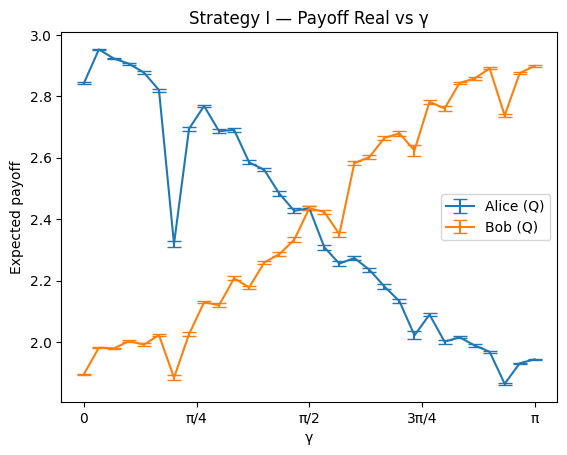

In [ ]:
# --- Figure 1: Real Payoff vs γ ---
fig3 = plt.figure()
plt.errorbar(gammas, EA_real, yerr=Err_EA_real, fmt='-', capsize=5, label='Alice (Q)')
plt.errorbar(gammas, EB_real, yerr=Err_EB_real, fmt='-', capsize=5, label='Bob (Q)')
plt.title("Strategy I — Real Payoff vs γ")
plt.xlabel("γ")
plt.ylabel("Expected payoff")
plt.legend()

# Configure X-axis with multiples of π
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(np.pi/4))  # ticks every π/4
ax.xaxis.set_major_formatter(FuncFormatter(pi_formatter))

path_payoff = f"/content/drive/MyDrive/Quantum/Code/Result/0_Strategie_I/{Intent}/Real/0_Real_Minimizada_strategy_I.png"
fig3.savefig(path_payoff, dpi=300, bbox_inches='tight')
print(f"[✓] Real payoff saved at: {path_payoff}")

plt.show()
plt.close(fig3)

[✓] Descoordinación real guardada en: /content/drive/MyDrive/Quantum/Code/Result/0_Strategie_I/5/Real/1_Descoordinacion_Minimizada_strategy_I.png


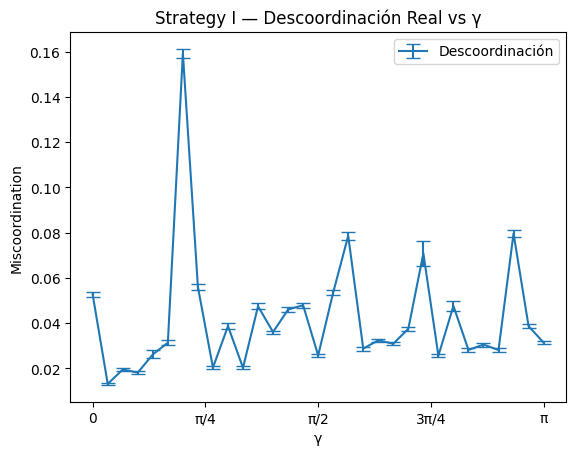

In [ ]:
# --- Figure 2: Real Miscoordination vs γ ---
fig4 = plt.figure()
plt.errorbar(gammas, Miscoord_real, yerr=Err_Miscoord_real, fmt='-', capsize=5, label='Miscoordination')
plt.title("Strategy I — Real Miscoordination vs γ")
plt.xlabel("γ")
plt.ylabel("Miscoordination")
plt.legend()

# Configure X-axis with multiples of π
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(np.pi/4))  # ticks every π/4
ax.xaxis.set_major_formatter(FuncFormatter(pi_formatter))

path_descoord = f"/content/drive/MyDrive/Quantum/Code/Result/0_Strategie_I/{Intent}/Real/1_Descoordinacion_Minimizada_strategy_I.png"
fig4.savefig(path_descoord, dpi=300, bbox_inches='tight')
print(f"[✓] Real miscoordination saved at: {path_descoord}")

plt.show()
plt.close(fig4)

[✓] Varianza guardada en: /content/drive/MyDrive/Quantum/Code/Result/0_Strategie_I/5/Real/2_Varianza_Minimizada_strategy_I.png


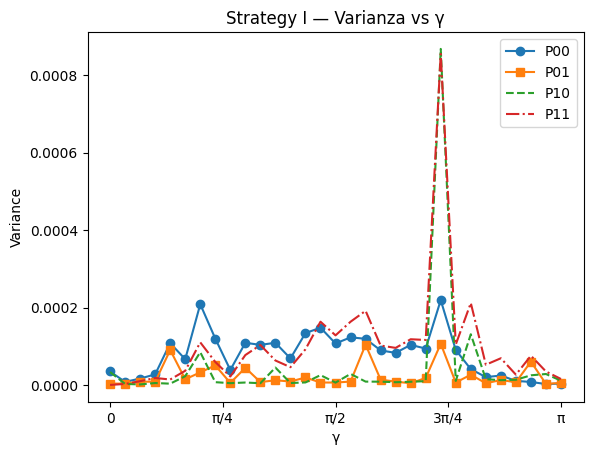

In [ ]:
# --- Figure 3: Variance of probabilities vs γ ---
fig5 = plt.figure()
plt.plot(gammas, P00_var, '-o', label='P00')
plt.plot(gammas, P01_var, '-s', label='P01')
plt.plot(gammas, P10_var, '--', label='P10')
plt.plot(gammas, P11_var, '-.', label='P11')
plt.title("Strategy I — Variance vs γ")
plt.xlabel("γ")
plt.ylabel("Variance")
plt.legend()

# Configure X-axis with multiples of π
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(np.pi/4))  # ticks every π/4
ax.xaxis.set_major_formatter(FuncFormatter(pi_formatter))

path_var = f"/content/drive/MyDrive/Quantum/Code/Result/0_Strategie_I/{Intent}/Real/2_Varianza_Minimizada_strategy_I.png"
fig5.savefig(path_var, dpi=300, bbox_inches='tight')
print(f"[✓] Variance saved at: {path_var}")

plt.show()
plt.close(fig5)

# 10. Comparison

In [ ]:
# Create the DataFrame
df_comp = pd.DataFrame({
    'strategy':      [strategy] * Num_exe,
    'γ':             list(np.linspace(0, np.pi, Num_exe)),
    'EA_sim':        EA_qs[:Num_exe],
    'EA_real':       EA_real,
    'ΔEA':           [s - r for s, r in zip(EA_qs[:Num_exe], EA_real)],
    'Err_EA_real':   Err_EA_real,
    'EB_sim':        EB_qs[:Num_exe],
    'EB_real':       EB_real,
    'ΔEB':           [s - r for s, r in zip(EB_qs[:Num_exe], EB_real)],
    'Err_EB_real':   Err_EB_real,
    'Mis_sim':       Err_qs[:Num_exe],
    'Mis_real':      Miscoord_real,
    'ΔMis':          [s - r for s, r in zip(Err_qs[:Num_exe], Miscoord_real)],
    'Err_Mis_real':  Err_Miscoord_real,
    'Var_P00':       P00_var,
    'Var_P01':       P01_var,
    'Var_P10':       P10_var,
    'Var_P11':       P11_var,
    'Time_real_s':   times_real
})

output_csv = f"/content/drive/MyDrive/Quantum/Code/Result/0_Strategie_I/{Intent}/CSV/tabla_strategy_I.csv"
os.makedirs(os.path.dirname(output_csv), exist_ok=True)
df_comp.to_csv(output_csv, index=False)
print(f"[✓] CSV saved at: {output_csv}")
print(tabulate(df_comp, headers='keys', tablefmt='fancy_grid', showindex=False))

[✓] CSV saved at: /content/drive/MyDrive/Quantum/Code/Result/0_Strategie_I/5/CSV/tabla_strategy_I.csv
╒════════════╤══════════╤══════════╤═══════════╤═══════════╤═══════════════╤══════════╤═══════════╤═══════════╤═══════════════╤═══════════╤════════════╤════════════╤════════════════╤═════════════╤═════════════╤═════════════╤═════════════╤═══════════════╕
│ strategy   │        γ │   EA_sim │   EA_real │       ΔEA │   Err_EA_real │   EB_sim │   EB_real │       ΔEB │   Err_EB_real │   Mis_sim │   Mis_real │       ΔMis │   Err_Mis_real │     Var_P00 │     Var_P01 │     Var_P10 │     Var_P11 │   Time_real_s │
╞════════════╪══════════╪══════════╪═══════════╪═══════════╪═══════════════╪══════════╪═══════════╪═══════════╪═══════════════╪═══════════╪════════════╪════════════╪════════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═══════════════╡
│ I          │ 0        │  3       │   2.84175 │ 0.15825   │    0.00318881 │  2       │   1.89544 │ 0.104555  │    0.00213985 │      

# 11. Histogram of absolute errors

[✓] EA comparison chart saved at: /content/drive/MyDrive/Quantum/Code/Result/0_Strategie_I/5/CSV/bar_EA_sim_vs_real_strategy_I.png


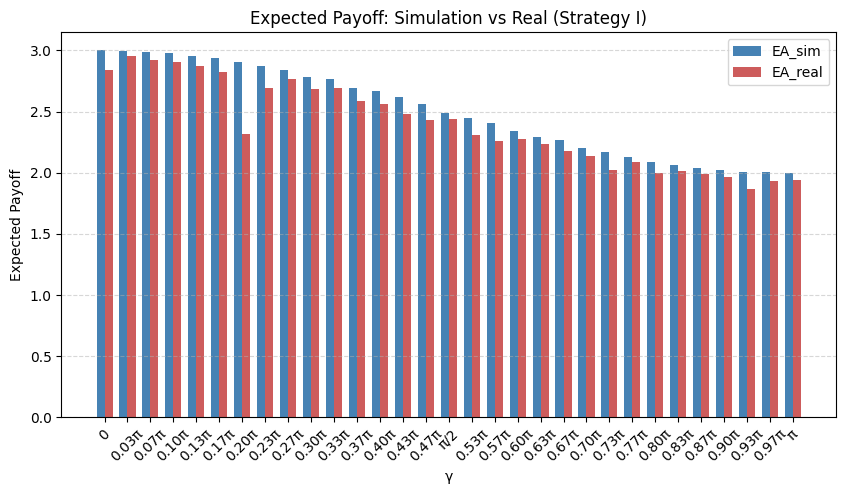

[✓] Miscoordination comparison chart saved at: /content/drive/MyDrive/Quantum/Code/Result/0_Strategie_I/5/CSV/bar_Mis_sim_vs_real_strategy_I.png


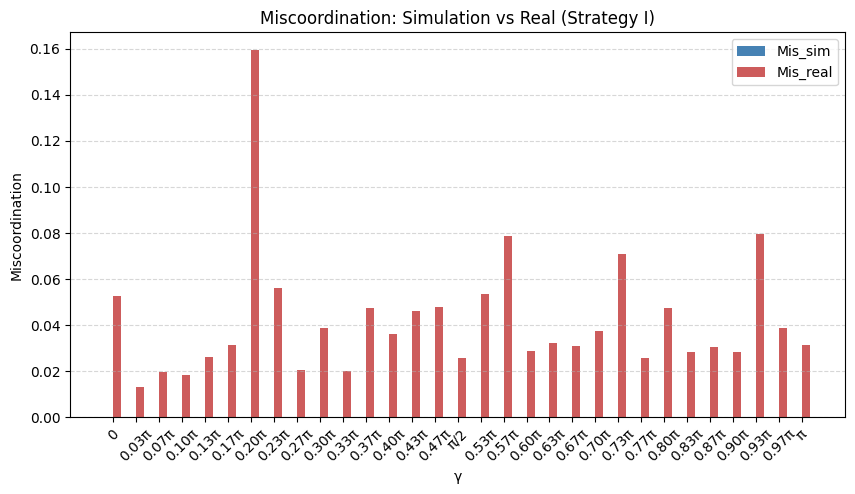

In [ ]:
gammas = df_comp['γ'].values
EA_sim = df_comp['EA_sim'].values
EA_real = df_comp['EA_real'].values
Mis_sim = df_comp['Mis_sim'].values
Mis_real = df_comp['Mis_real'].values

# Positions for the bars
indices = np.arange(len(gammas))
width   = 0.35

# π Formatter
def pi_formatter(x, pos):
    frac = x / np.pi
    if np.isclose(frac, 0):      return "0"
    elif np.isclose(frac, 0.25): return "π/4"
    elif np.isclose(frac, 0.5):  return "π/2"
    elif np.isclose(frac, 0.75): return "3π/4"
    elif np.isclose(frac, 1.0):  return "π"
    else:                         return f"{frac:.2f}π"

# --- Plot of EA_sim vs EA_real ---
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(indices - width/2, EA_sim,  width, label='EA_sim', color='steelblue')
ax.bar(indices + width/2, EA_real, width, label='EA_real', color='indianred')

ax.set_title("Expected Payoff: Simulation vs Real (Strategy I)")
ax.set_xlabel("γ")
ax.set_ylabel("Expected Payoff")
ax.set_xticks(indices)
ax.set_xticklabels([pi_formatter(g, None) for g in gammas], rotation=45)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)

path1 = f"/content/drive/MyDrive/Quantum/Code/Result/0_Strategie_I/{Intent}/CSV/bar_EA_sim_vs_real_strategy_I.png"
os.makedirs(os.path.dirname(path1), exist_ok=True)
plt.savefig(path1, dpi=300, bbox_inches='tight')
print(f"[✓] EA comparison chart saved at: {path1}")
plt.show()
plt.close()

# --- Plot of Mis_sim vs Mis_real ---
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(indices - width/2, Mis_sim,  width, label='Mis_sim', color='steelblue')
ax.bar(indices + width/2, Mis_real, width, label='Mis_real', color='indianred')

ax.set_title("Miscoordination: Simulation vs Real (Strategy I)")
ax.set_xlabel("γ")
ax.set_ylabel("Miscoordination")
ax.set_xticks(indices)
ax.set_xticklabels([pi_formatter(g, None) for g in gammas], rotation=45)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)

path2 = f"/content/drive/MyDrive/Quantum/Code/Result/0_Strategie_I/{Intent}/CSV/bar_Mis_sim_vs_real_strategy_I.png"
os.makedirs(os.path.dirname(path2), exist_ok=True)
plt.savefig(path2, dpi=300, bbox_inches='tight')
print(f"[✓] Miscoordination comparison chart saved at: {path2}")
plt.show()
plt.close()